In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
#from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, text, inspect, func, desc

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\d_ang\AppData\Local\Temp\ipykernel_18864\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [32]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [33]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [36]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

'2017-08-23'

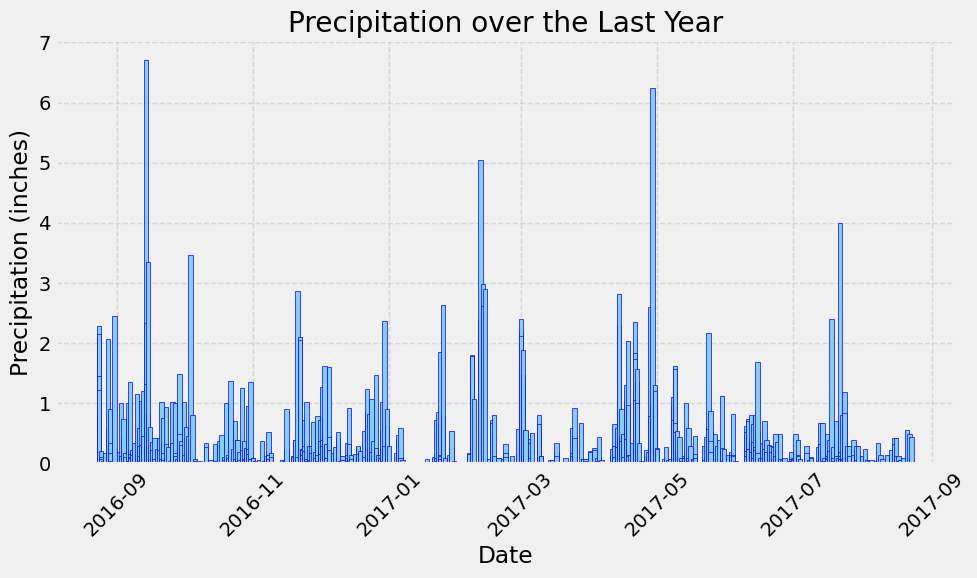

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.

one_year_ago = most_recent_date_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df = precipitation_df.sort_values('date')


# Sort the dataframe by date
precipitation_df.sort_values(by='date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['date'], precipitation_df['precipitation'], width=2, color='skyblue', edgecolor='blue')
plt.title('Precipitation over the Last Year')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()

#come back later to fix something is wrong 

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()
summary_statistics 
#this is wrong, need to fix the query at the top

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
#df = pd.read_csv('hawaii_stations.csv')

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                                .group_by(Measurement.station)
                                .order_by(desc(func.count(Measurement.station)))
                                .all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
(session.query(func.min(Measurement.tobs), 
               func.max(Measurement.tobs), 
               func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all())

[(54.0, 85.0, 71.66378066378067)]

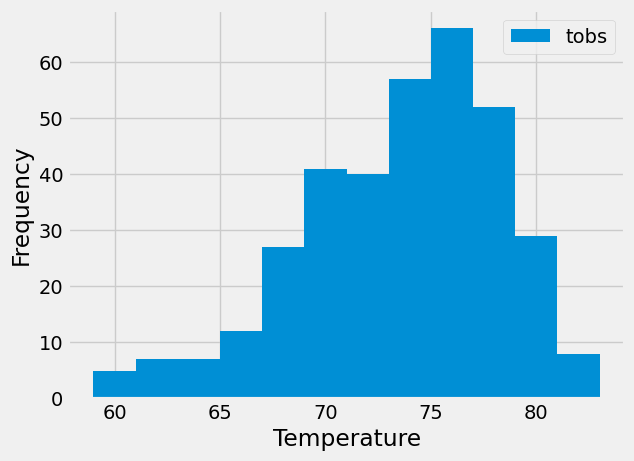

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months_data = (session.query(Measurement.tobs)
                       .filter(Measurement.station == most_active_station_id)
                       .filter(Measurement.date >= one_year_ago)
                       .all())
temperatures = [temp[0] for temp in last_12_months_data]


plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()